# Assignment 4 - CNN - FashionMnist


## Notes
(schrijf hier notities op over de code)





### Get data
Laden vd data aan de hand van pytorhc tutorial:
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

Over de data:
Fashion-MNIST is a dataset of Zalando’s article images consisting of 60,000 training examples and 10,000 test examples. Each example comprises a 28×28 grayscale image and an associated label from one of 10 classes.

In [ ]:
# install packages
!pip install torchvision
!pip install mnist_reader
!pip install torchsummary

In [13]:
import numpy as np
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torch import nn
from torchsummary import summary
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
from torchvision.transforms import ToTensor, Normalize, Compose, RandomHorizontalFlip, RandomRotation, ColorJitter, RandomErasing

In [4]:
# set seed for reproducibility
torch.manual_seed(12) # voor torch
random.seed(12) # for other py functions


In [ ]:
# import data (from pytorch site)
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor() # MOET HIERONDER NIET OOK TARGET_TRANSFORM BIJ OM LABELS NAAR ONE-HOT TE DOEN?
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [6]:
from torch.utils.data import DataLoader

# divide into train and validation sets
fraction_train = 0.8
total_samples = len(training_data)
train_size = int(fraction_train * total_samples)
validation_size = total_samples - train_size
train_dataset, val_dataset = torch.utils.data.random_split(training_data, [train_size, validation_size])

# prep data for training, validation and testing
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [7]:
images, labels = next(iter(train_dataloader))
print('shape of batch of images:', images.shape)

shape of batch of images: torch.Size([32, 1, 28, 28])


## Visualisation

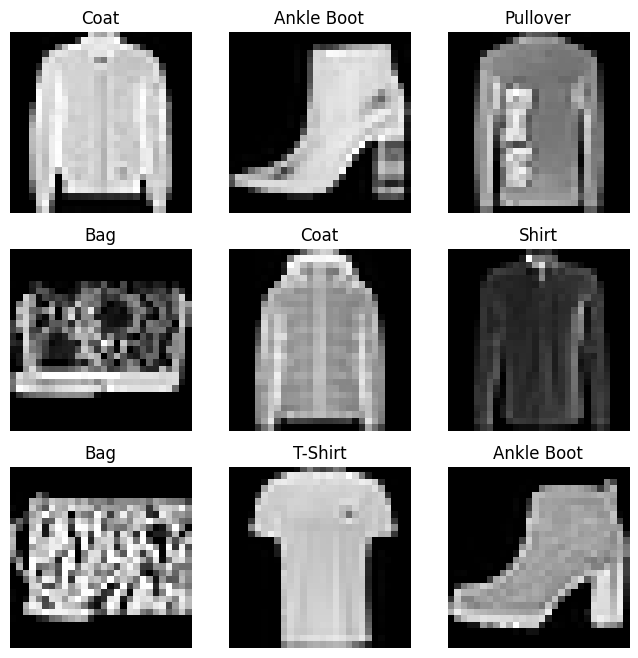

In [8]:
# example visualisation
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


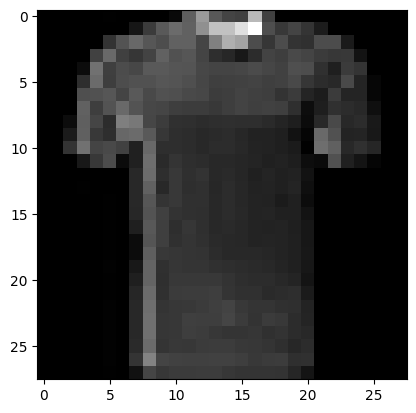

Label: 0


In [ ]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## Build LeNet5

van tutorial: https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

Plaatje hieronder gebruikt images van 32x32, wij hebben 28x28


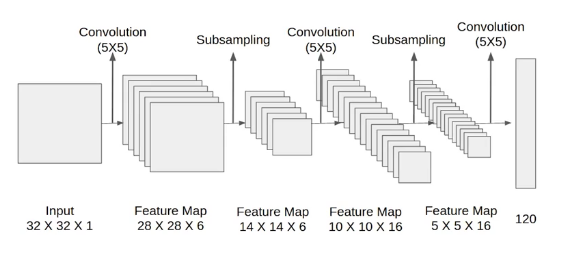

### Variant 4 = variant 3 + dropout


In [10]:
# verschillende dropouts geprobeerd > beste 0.25 in fc layers
# geprobeerde dropouts: 0.1, 0.15, 0.25, 0.5 , hoe hoger de dropout hoe lager de performance.
# in conv layer lager dan in fc layers
class LeNet5_Dropout(nn.Module):
    def __init__(self):
        super().__init__()

        """ adjust filter size """
        # First convolutional layer: using a smaller kernel size (3x3) to capture finer details.
        # Adjusted padding to 1 to maintain output size of 28x28x6.
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32), # add batchNorm, 32 features
            nn.ReLU())

        # Average pool layer / subsampling,
        # output size remains 14x14x6.
        self.avg_pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        # Second convolutional layer, using 3x3 kernels , 16 filters
        # Adjusted padding to maintain the intended output size dimensions. >> kan niet? Dan moet padding -1 zijn?
        # output size NEW: 12x12x16 (was 10x10x16 met kernel size 5 en padding=0)
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(32), # add batchNorm, 32 features
            nn.ReLU())

        # Adjusting the average pooling to accommodate changes in feature map size,
        # output size: 6x6x16. (BERBER): is het erg dat dit even is? Eeerst was het 5x5
        self.avg_pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        " added dropout "
        # fully connected layer 1: output 120 feature maps
        # new input (want aangepast): dus input 6x6x120
        # output = 120 feeature maps
        self.ful_conn1 = nn.Sequential(
            nn.Linear(in_features=6*6*32, out_features=120),
            nn.ReLU(),
            nn.Dropout(0.25)) # add dropout

        " added dropout "
        # Fully connected layer 2
        # output = 84 features
        self.ful_conn2 = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Dropout(0.25)) # add dropout

        # final output: 10 classes, no softmax apparently (since the loss func does that automatically????)
        self.ful_conn3 = nn.Linear(84, 10)

    def _reset_parameters(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu') # for initializing the weights
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    " Return the embedding from the second fully connected layer (voor choice task) "
    def forward(self, x, return_embedding=False):
        out = self.layer1(x)
        out = self.avg_pool1(out)
        out = self.layer3(out)
        out = self.avg_pool2(out)
        out = out.view(out.size(0), -1)  # Flatten
        out = self.ful_conn1(out)
        out = self.ful_conn2(out)
        if return_embedding:
            return out
        out = self.ful_conn3(out)
        return out

In [9]:
def train(dataloader, model, loss_func, optimizer):
    # set to train mode
    model.train()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0

    for batch, (X, y) in enumerate(dataloader):

        # prediction and loss > forqard pass
        pred = model(X)
        loss = loss_func(pred, y)

        # backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    train_loss /= num_batches
    correct /= size
    return train_loss, 100 * correct


def val(dataloader, model, loss_func):
    # set to evaluate instead of train
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            val_loss += loss_func(pred, y).item() #get loss over validation set
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    val_loss /= num_batches
    correct /= size
    return val_loss, 100 * correct

def plot_performance(train_losses, val_losses, train_accuracies, val_accuracies):
    """Plot the training and validation loss and accuracy."""
    plt.figure(figsize=(12, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over Epochs')

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Accuracy over Epochs')

    plt.tight_layout()
    plt.show()

def generate_confusion_matrix(model, dataloader, labels_map, show=True):
    model.eval()

    all_preds = torch.tensor([])
    all_labels = torch.tensor([])

    with torch.no_grad():
        for X, y in dataloader:
            preds = model(X)
            all_preds = torch.cat((all_preds, preds), dim=0)
            all_labels = torch.cat((all_labels, y), dim=0)

    predicted_labels = all_preds.argmax(dim=1)
    cm = confusion_matrix(all_labels.numpy(), predicted_labels.numpy())
    label_names = [labels_map[i] for i in range(len(labels_map))]

    if show:
      plt.figure(figsize=(10,8))
      sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
      plt.xlabel('Predicted Labels')
      plt.ylabel('True Labels')
      plt.title('Confusion Matrix')
      plt.show()

    return cm

In [ ]:
model_Dropout = LeNet5_Dropout()
model_Dropout._reset_parameters()

learning_rate = 1e-3  #0.001
loss_func = nn.CrossEntropyLoss() # cross entropy loss
optimizer = torch.optim.Adam(model_Dropout.parameters(), lr=learning_rate)
epochs = 12

train_losses4, val_losses4 = [], []
train_accuracies4, val_accuracies4 = [], []

def plot_performance(train_losses, val_losses, train_accuracies, val_accuracies):
    """Plot the training and validation loss and accuracy."""
    plt.figure(figsize=(12, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over Epochs - LeNet5_Dropout')

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Accuracy over Epochs')

    plt.tight_layout()
    plt.show()

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss4, train_accuracy4 = train(train_dataloader, model_Dropout, loss_func, optimizer)
    val_loss4, val_accuracy4 = val(val_dataloader, model_Dropout, loss_func)
    train_losses4.append(train_loss4)
    val_losses4.append(val_loss4)
    train_accuracies4.append(train_accuracy4)
    val_accuracies4.append(val_accuracy4)
    print(f"Train Loss: {train_loss4:.4f}, Accuracy: {train_accuracy4:.2f}%")
    print(f"Validation Loss: {val_loss4:.4f}, Accuracy: {val_accuracy4:.2f}%")
print("Done!")

# Plott performance (loss en acc, loss hoeft alleen voor opdracht)
plot_performance(train_losses4, val_losses4, train_accuracies4, val_accuracies4)

# Saving model params
torch.save(model_Dropout.state_dict(), 'model_weights_Dropout.pth')
print("Model parameters and weights saved as 'model_weights_Dropout.pth'.")

summary(model_Dropout, input_size=(1, 28, 28))

### Variant 4 - on Test set with just train set as previously used

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

modelTrainTest = LeNet5_Dropout()
modelTrainTest.load_state_dict(torch.load('model_weights_Dropout.pth')) # je moet deze ff los uploaden in colab : of /content/model_weights_Dropout.pth


<All keys matched successfully>

In [15]:
# Move the model to the correct device (GPU or CPU)
modelTrainTest = modelTrainTest.to(device) # device should be 'cuda' or 'cpu'

# Function to evaluate the model on the test set
def evaluate_model(dataloader, model):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No need to calculate gradients
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device) # Move data to the correct device
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy of the model on the test images: {100 * correct / total}%')

# Test the model
evaluate_model(test_dataloader, modelTrainTest)

# kan eig vgm ook met de val functie die we hele tijd gebruikt hadden:
loss_func = nn.CrossEntropyLoss()
val(test_dataloader, modelTrainTest, loss_func)


Accuracy of the model on the test images: 91.9%


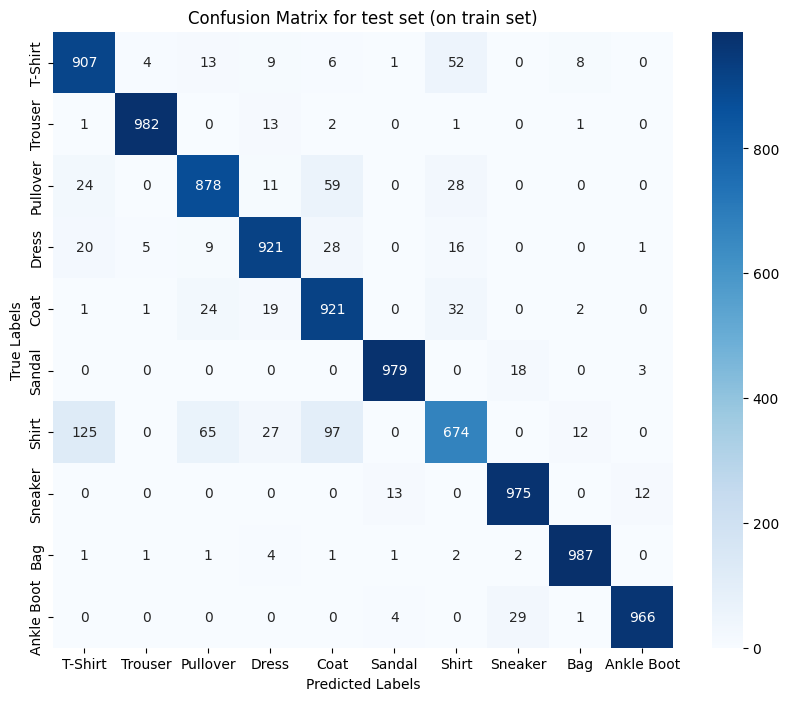

In [18]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

def generate_and_plot_confusion_matrix(model, dataloader, device):
    model.eval()
    model.to(device)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(labels_map.values()), yticklabels=list(labels_map.values()))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for test set (on train set)')
    plt.show()

# Generate and plot confusion matrix for the model on the test set
generate_and_plot_confusion_matrix(modelTrainTest, test_dataloader, device)


### Variant 4 - on Test set with train and val set as net train set

In [ ]:
# combining train + val
# training_data die initieel is ingeladen dus in z'n totaliteit gebruiken om model te trianen:
trainingFull_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)

# Initialize a new model
modelTrainFull = LeNet5_Dropout()
modelTrainFull = modelTrainFull.to(device) # Ensure model is on the correct device

learning_rate = 1e-3  #0.001
loss_func = nn.CrossEntropyLoss() # cross entropy loss
optimizer = torch.optim.Adam(modelTrainFull.parameters(), lr=learning_rate)
epochs = 12

# Training loop for the new model
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_accuracy = train(trainingFull_dataloader, modelTrainFull, loss_func, optimizer)
    print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
print("Done!")


# After training, evaluate the new model on the test set
evaluate_model(test_dataloader, modelTrainFull)

# Saving model params
torch.save(modelTrainFull.state_dict(), 'model_weights_DropoutFULLTrain.pth')
print("Model parameters and weights saved as 'model_weights_DropoutFULLTrain.pth'.")

summary(modelTrainFull, input_size=(1, 28, 28))

In [ ]:
def generate_and_plot_confusion_matrix(model, dataloader, device):
    model.eval()
    model.to(device)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(labels_map.values()), yticklabels=list(labels_map.values()))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for test set (on FULL train set)')
    plt.show()

#  plot confusion matrix for the model on the test set
generate_and_plot_confusion_matrix(modelTrainFull, test_dataloader, device)

# Test the model
evaluate_model(test_dataloader, modelTrainFull)

# kan eig vgm ook met de val functie die we hele tijd gebruikt hadden:
loss_func = nn.CrossEntropyLoss()
val(test_dataloader, modelTrainFull, loss_func)

## Choice task 4: data augmentation

In [ ]:
#  train set = 80% vd original train set
#  val set = 20% vd original train set
#  augmented train set = augmented data from the train set
#  nieuwe train set = augmented train set + train set
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision.transforms import Compose, RandomRotation, ColorJitter, ToTensor, Normalize, RandomHorizontalFlip
from torchvision.transforms import GaussianBlur


# Augmentation transformations
augmentation_transforms = transforms.Compose([
    #transforms.RandomHorizontalFlip(),  # Uncomment if desired
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    #transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the original training and test data
original_training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

# Dit blijft dus nog hetzelfde (alleen nu met original_training_data)
fraction_train = 0.8
total_samples = len(original_training_data)
train_size = int(fraction_train * total_samples)
validation_size = total_samples - train_size
train_data, validation_data = random_split(original_training_data, [train_size, validation_size])

# Create an augmented dataset
# IMPORTANT: Since random_split does not directly give a dataset compatible with transforms,
# >> apply transforms after splitting >> DatasetFromSubset class workaround
class DatasetFromSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

# augmentation to the training subset
train_data_augmented = DatasetFromSubset(train_data, transform=augmentation_transforms)

# Combine the original and augmented training data
combined_train_data = ConcatDataset([train_data, train_data_augmented])

# DataLoader for the combined training set, validation set, and test set
batch_size = 32
train_dataloader = DataLoader(combined_train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)


In [ ]:
# model gebruiken van LeNet5_Dropout
model_Dropout_Augmented = LeNet5_Dropout()
model_Dropout_Augmented._reset_parameters()

learning_rate = 1e-3  #0.001
loss_func = nn.CrossEntropyLoss() # cross entropy loss
optimizer = torch.optim.Adam(model_Dropout_Augmented.parameters(), lr=learning_rate)
epochs = 12

train_losses5, val_losses5 = [], []
train_accuracies5, val_accuracies5 = [], []

def plot_performance(train_losses, val_losses, train_accuracies, val_accuracies):
    """Plot the training and validation loss and accuracy."""
    plt.figure(figsize=(12, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over Epochs - LeNet5_Dropout')

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Accuracy over Epochs')

    plt.tight_layout()
    plt.show()

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss5, train_accuracy5 = train(train_dataloader, model_Dropout_Augmented, loss_func, optimizer)
    val_loss5, val_accuracy5 = val(val_dataloader, model_Dropout_Augmented, loss_func)
    train_losses5.append(train_loss5)
    val_losses5.append(val_loss5)
    train_accuracies5.append(train_accuracy5)
    val_accuracies5.append(val_accuracy5)
    print(f"Train Loss: {train_loss5:.4f}, Accuracy: {train_accuracy5:.2f}%")
    print(f"Validation Loss: {val_loss5:.4f}, Accuracy: {val_accuracy5:.2f}%")
print("Done!")

# Plott performance (loss en acc, loss hoeft alleen voor opdracht)
plot_performance(train_losses5, val_losses5, train_accuracies5, val_accuracies5)

# Saving model params
torch.save(model_Dropout_Augmented.state_dict(), 'model_weights_Dropout_Augmented.pth')
print("Model parameters and weights saved as 'model_weights_Dropout_Augmented.pth'.")

summary(model_Dropout_Augmented, input_size=(1, 28, 28))

generate_confusion_matrix(model_Dropout_Augmented, val_dataloader, labels_map)

In [ ]:
# visualiseren vd augmented data (dit overigens op de hele nieuwe train set dus zitten ook de 'gewone' samples in)

def get_one_image_per_class(dataloader, class_names):
    # Initialize dict to hold one image per class
    class_images = {class_name: None for class_name in class_names}
    seen_classes = set()

    for images, labels in dataloader:
        for image, label in zip(images, labels):
            class_name = class_names[label]
            if class_name not in seen_classes:
                # Store image and update seen_classes
                class_images[class_name] = image
                seen_classes.add(class_name)
            # Break loop if all classes seen
            if len(seen_classes) == len(class_names):
                break
        if len(seen_classes) == len(class_names):
            break

    return class_images

fashion_mnist_classes = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Get one image per class
class_images = get_one_image_per_class(train_dataloader, fashion_mnist_classes)

# Visualize one image per class
def show_one_image_per_class(class_images):
    fig, axs = plt.subplots(1, len(class_images), figsize=(15, 15))
    for ax, (class_name, image) in zip(axs, class_images.items()):
        ax.imshow(image.squeeze(), cmap='gray')
        ax.set_title(class_name)
        ax.axis('off')

    plt.show()

show_one_image_per_class(class_images)


## Choice task 5 - t-SNE (!! MOET NOG OP TEST SET)

In [ ]:
# nu nog op validation set: voor test set: test_dataloader gebruiken !
# eerste was on model_dropout & val_dataloader
# A) is on modelTrainTest & test_dataloader
# B) is on modelTrainValTest & test_dataloader
from sklearn.manifold import TSNE

modelTrainFull.eval()  # Set the model to evaluation mode

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

# Extract embeddings and labels
embeddings = []
labels = []

with torch.no_grad():
    for X, y in test_dataloader:  # voor nu nog ff val > moet ook op test?!
        embedding = modelTrainFull(X, return_embedding=True)  #
        embeddings.append(embedding)
        labels.append(y)

embeddings = torch.cat(embeddings).cpu().numpy()
labels = torch.cat(labels).cpu().numpy()

# Get class names ipv nmrs
descriptive_labels = np.array([labels_map[label] for label in labels])

# t-SNE
tsne = TSNE(n_components=2, random_state=22)
embeddings_2d = tsne.fit_transform(embeddings)

# Visualization
plt.figure(figsize=(10, 8))
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=descriptive_labels, palette=sns.color_palette("hsv", 10), legend='full')
plt.title('t-SNE of the last fully connected layer before the output layer (on train set B)')
plt.xlabel('t-SNE dim 1')
plt.ylabel('t-SNE dim 2')

# legenda met class labels
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles[1:], labels=labels[1:], title='Clothing Item', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()
